# Импорты

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from src import business, modeling, transforms, vis
from src.const import DATA_PATH

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150
%load_ext autoreload
%autoreload 2

# Работа

In [2]:
loan_data = pd.read_csv(DATA_PATH)
loan_data

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,сбор,срок,...,один_платеж,стоимость_имущества,проживание,тип_залога,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,дефолт,речь
0,0.0,м,3.0,0.0,1.0,NaN,0.0,174765.264968,normal,245.885949,...,0.0,244488.111841,осн,дом,2.0,709.508335,55-64,1.0,0,"""Hey there! I’m a guy with a solid job and a m..."
1,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,want,365.885949,...,0.0,NaN,осн,дом,1.0,722.508335,55-64,NaN,0,"""Hi there! We are a couple with a solid financ..."
2,0.0,м,3.0,1.0,1.0,0.0,0.0,NaN,regular,365.885949,...,NaN,364488.111841,осн,дом,1.0,785.508335,55-64,1.0,0,"""I'm a male client with a modest income. I wor..."
3,0.0,NaN,3.0,1.0,1.0,0.0,0.0,474765.264968,common,365.885949,...,0.0,894488.111841,осн,дом,NaN,594.508335,35-44,1.0,0,"""Hello, we’re a working couple enjoying the st..."
4,0.0,NaN,3.0,1.0,NaN,0.0,0.0,384765.264968,excessive,365.885949,...,0.0,504488.111841,осн,дом,NaN,589.508335,55-64,NaN,0,"""Greetings, we're Chris and Sam. Both employed..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,NaN,3.0,1.0,NaN,0.0,0.0,NaN,not slight,125.885949,...,0.0,744488.111841,осн,дом,2.0,NaN,35-44,NaN,0,"""Hello! I’m here to introduce myself. I have a..."
7996,NaN,NaN,NaN,1.0,1.0,0.0,1.0,NaN,mean,185.885949,...,0.0,184488.111841,осн,дом,1.0,796.508335,>74,1.0,0,"""Hello! I’m excited to be here. My income is m..."
7997,0.0,м,3.0,3.0,1.0,NaN,0.0,394765.264968,Whole lotta nothin',365.885949,...,0.0,NaN,осн,дом,4.0,584.508335,25-34,1.0,1,"""I'm just an ordinary guy trying to make ends ..."
7998,NaN,NaN,NaN,1.0,1.0,0.0,0.0,594765.264968,Total lack of presence,365.885949,...,0.0,NaN,осн,дом,NaN,873.508335,35-44,1.0,0,"""Hello! We’re a couple looking to manage our f..."


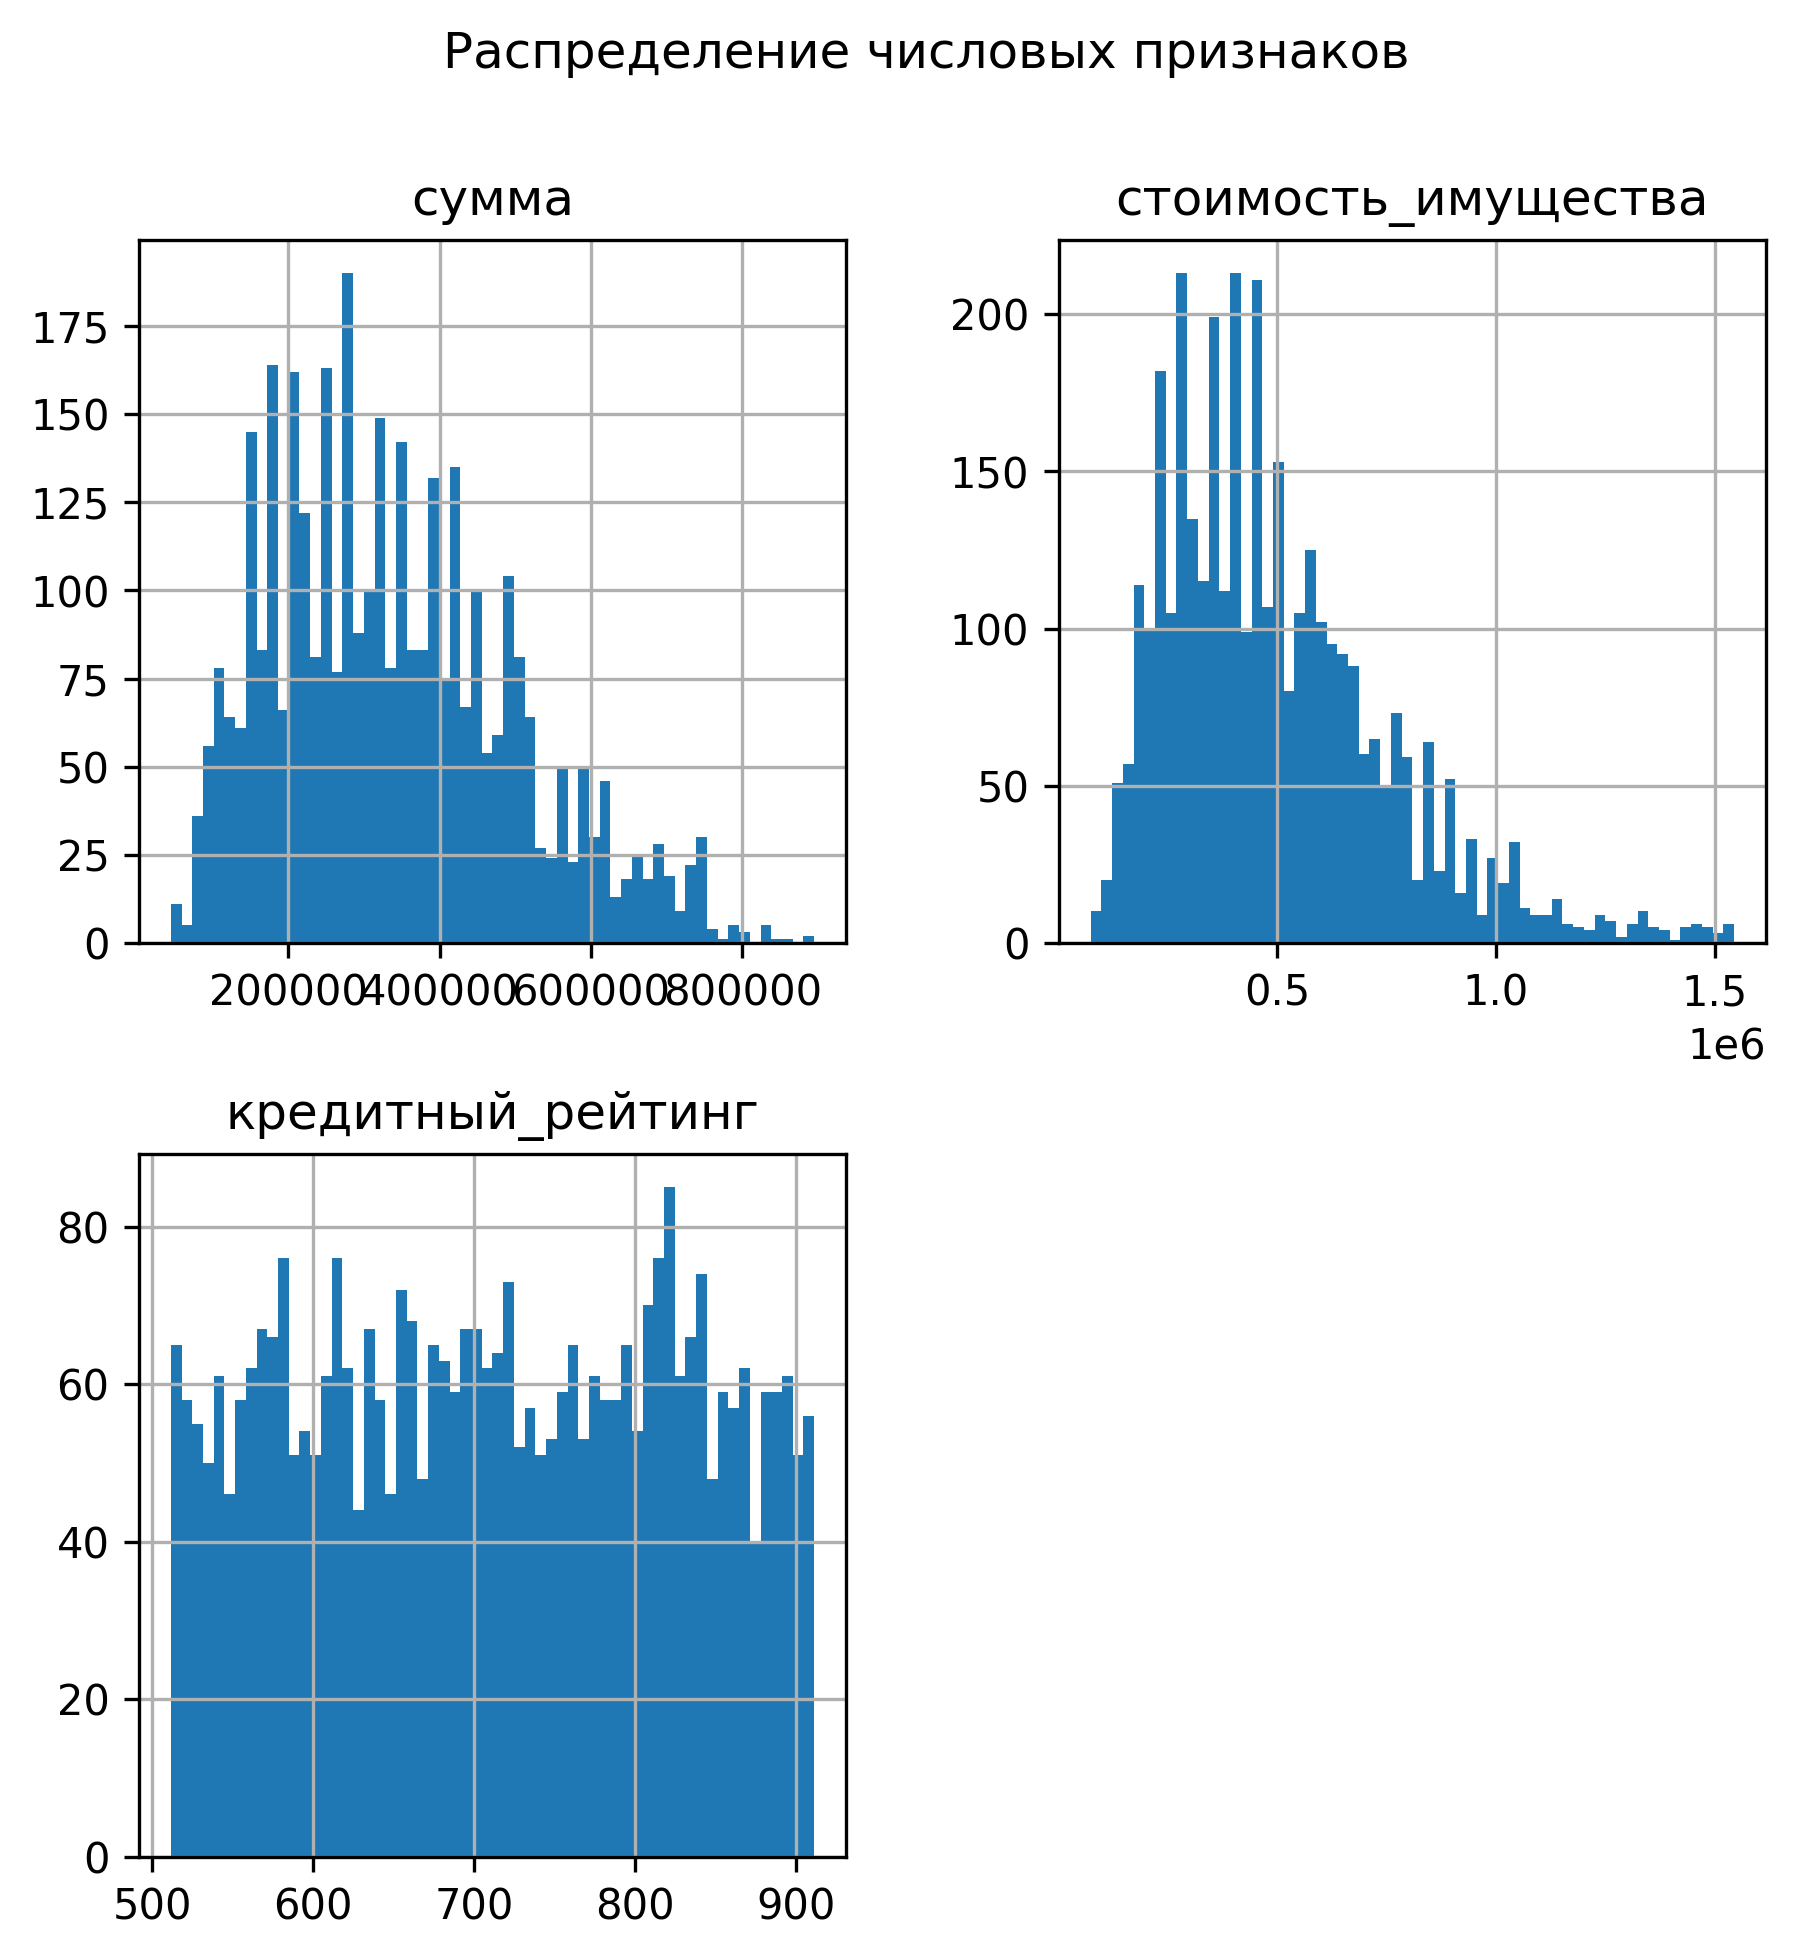

In [3]:
float_cols = ["сумма", "стоимость_имущества", "кредитный_рейтинг"]
vis.plot_hist(transforms.remove_anomalies(loan_data[float_cols], float_cols), float_cols)

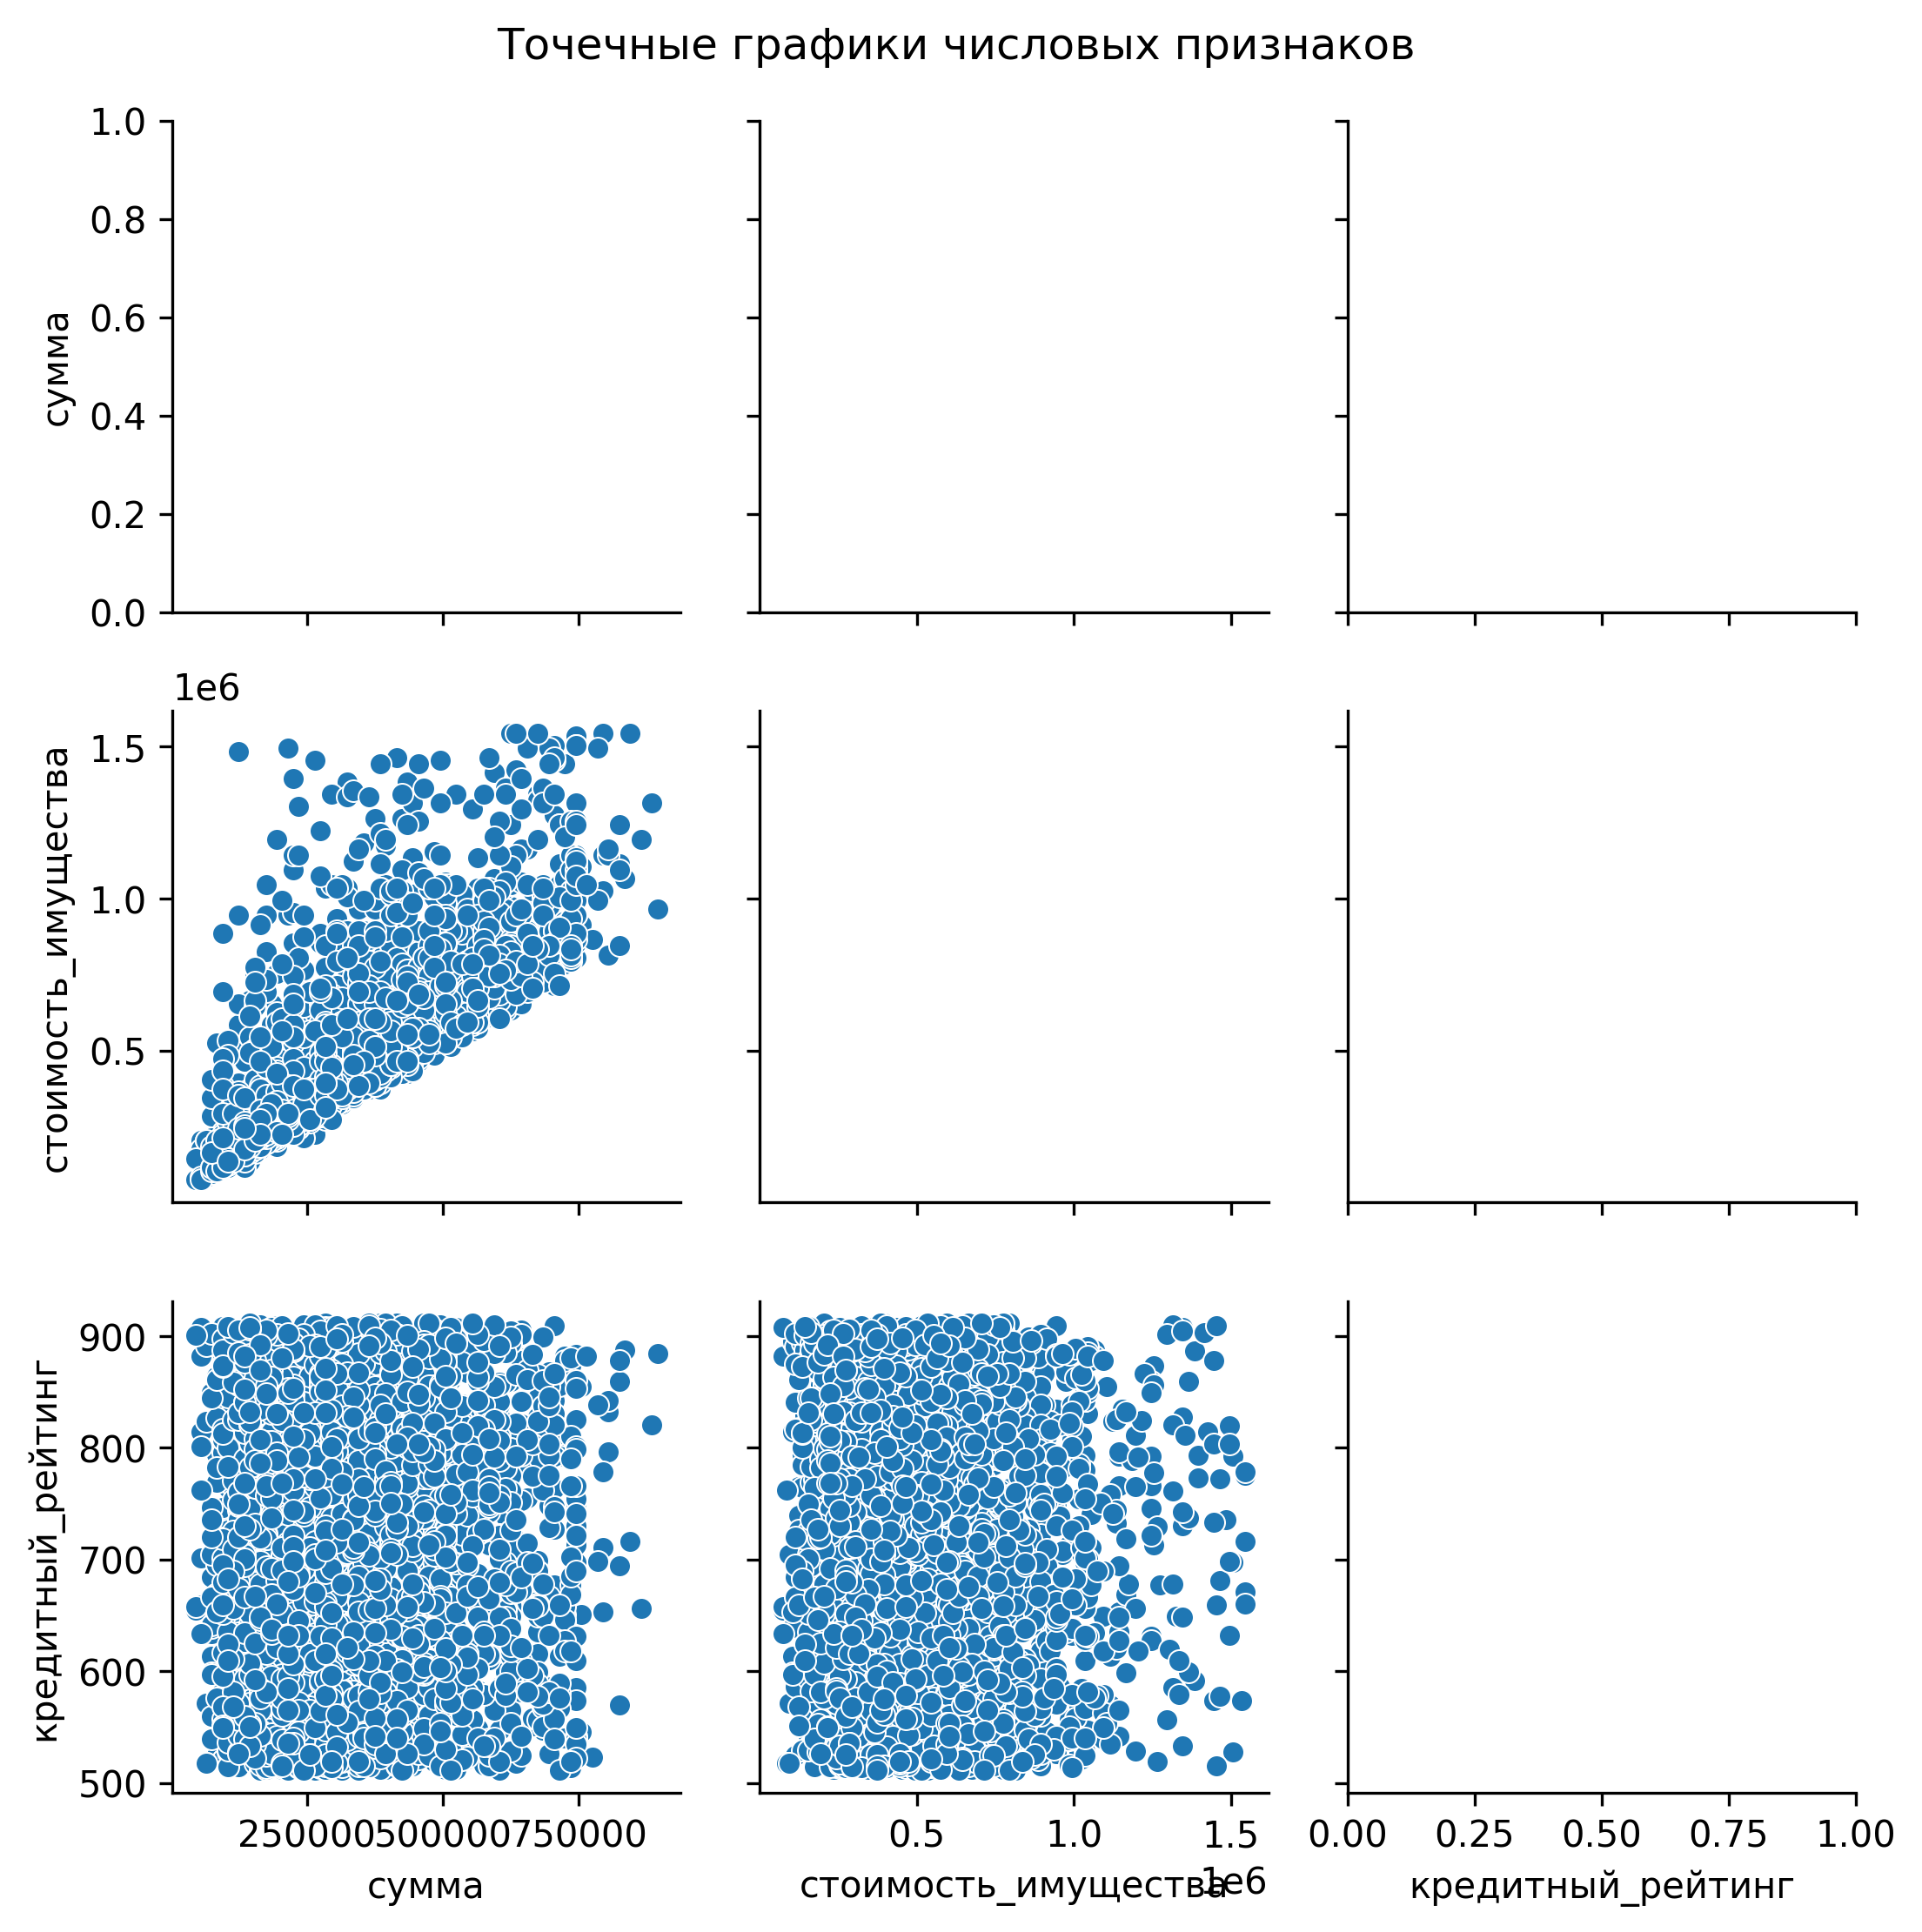

In [4]:
float_cols = ["сумма", "стоимость_имущества", "кредитный_рейтинг"]
vis.plot_scatter(transforms.remove_anomalies(loan_data[float_cols], float_cols), float_cols)

### Пропуски

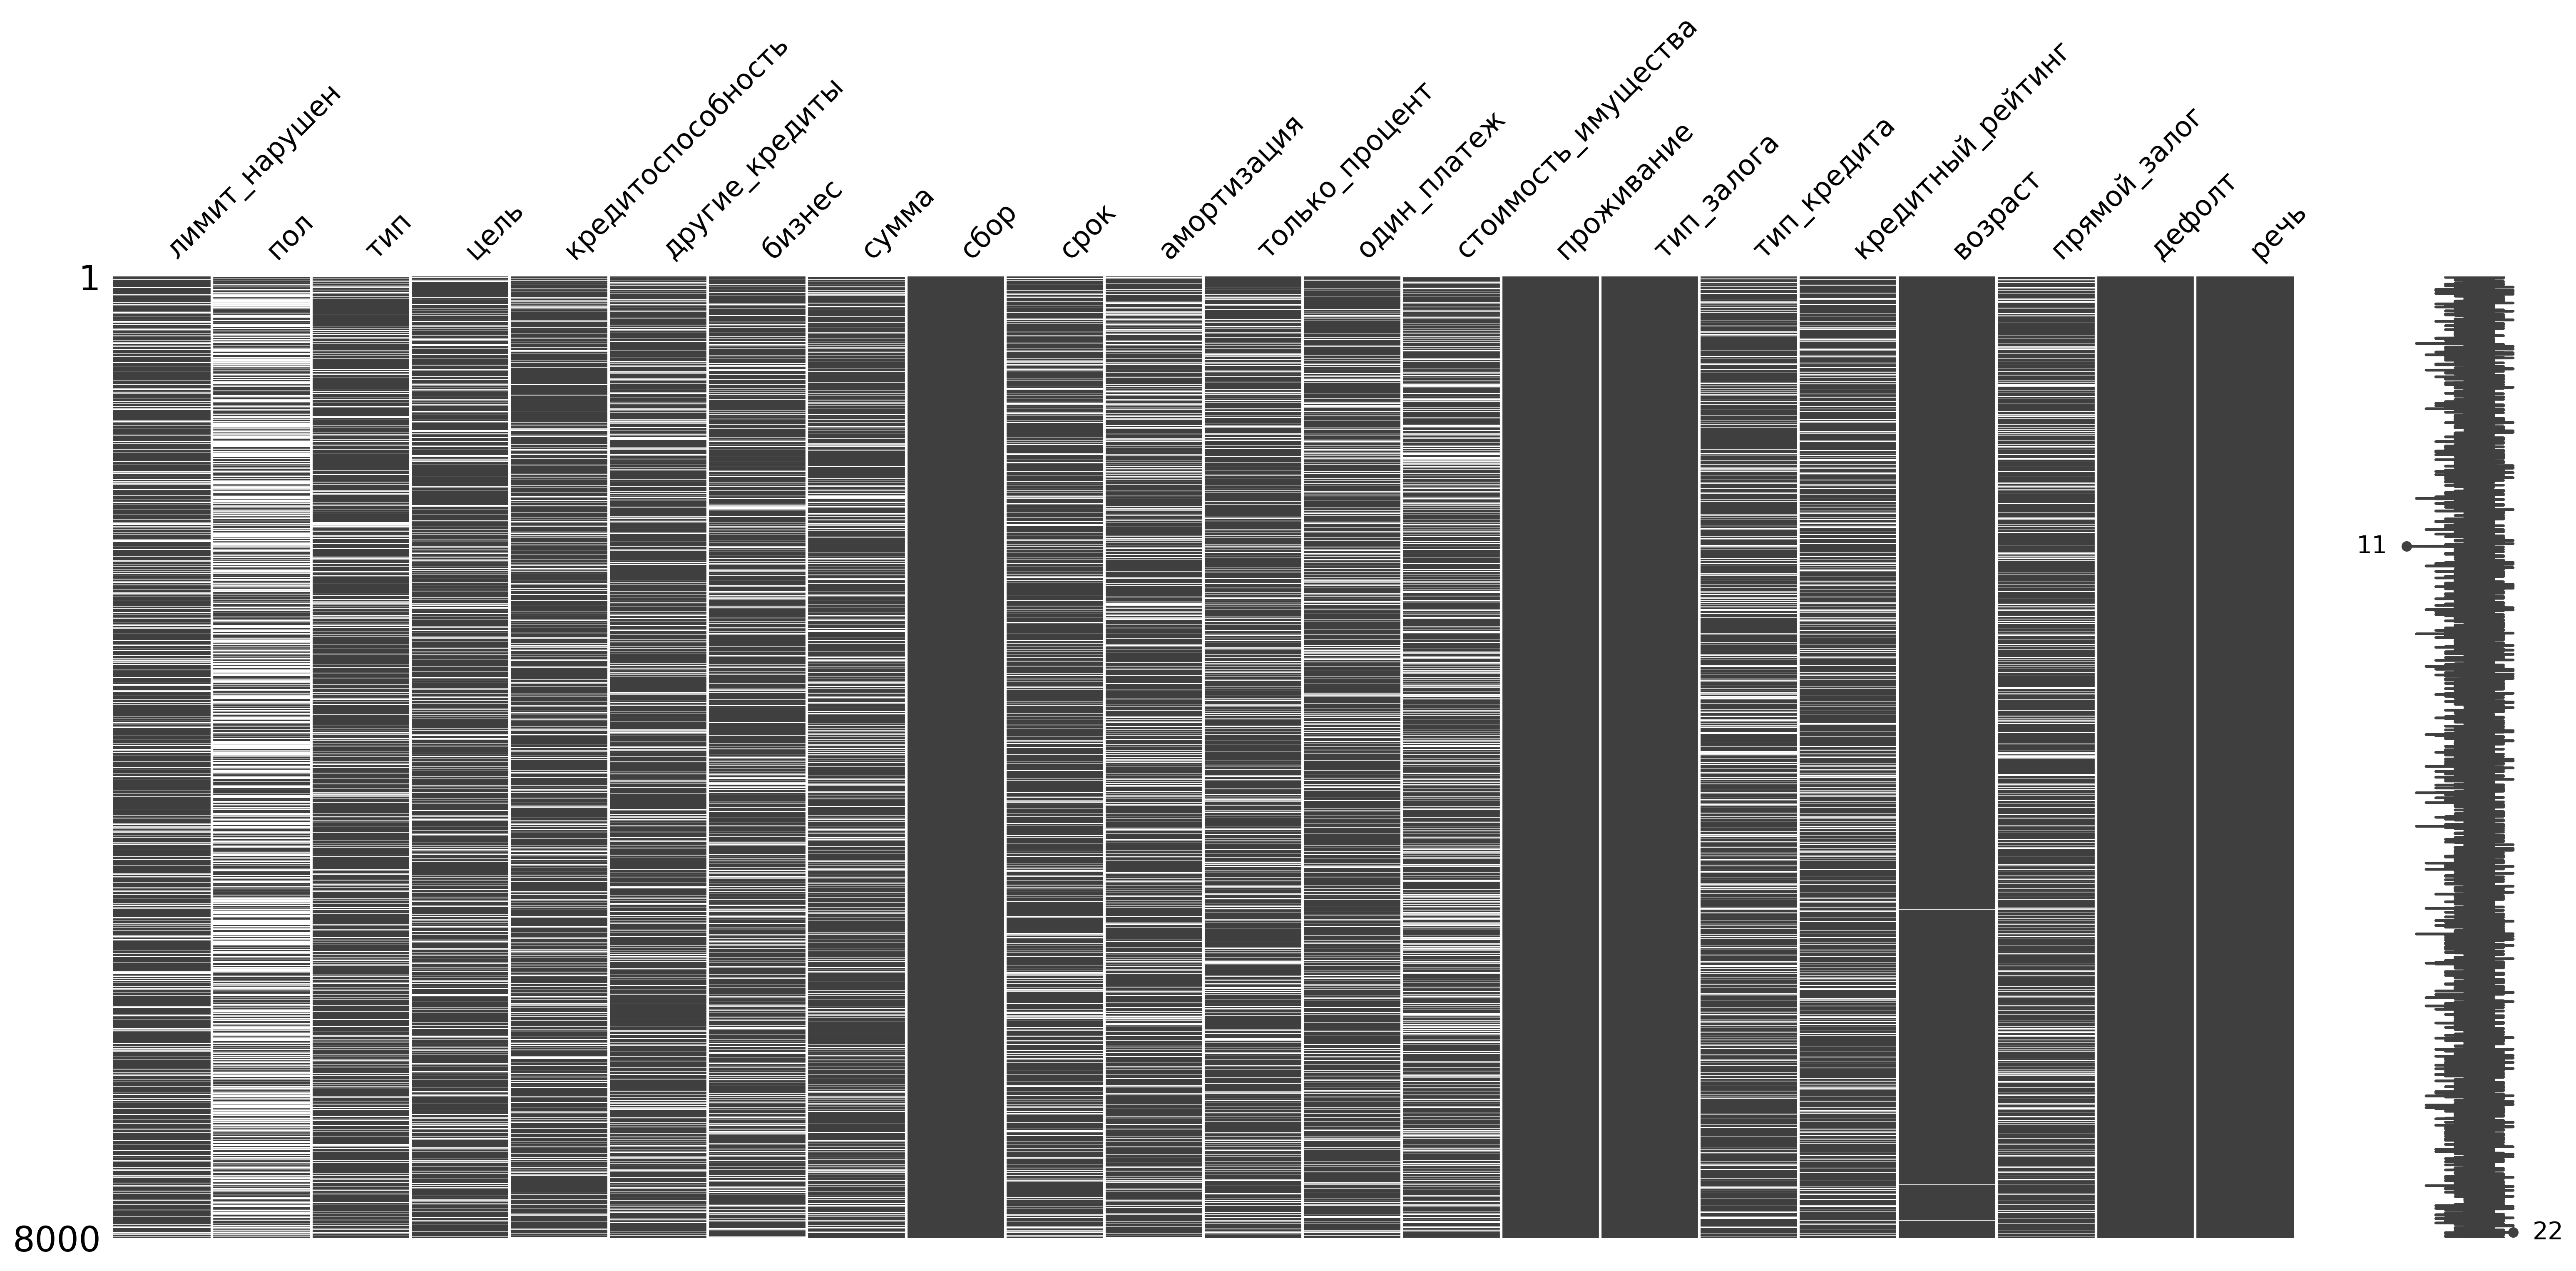

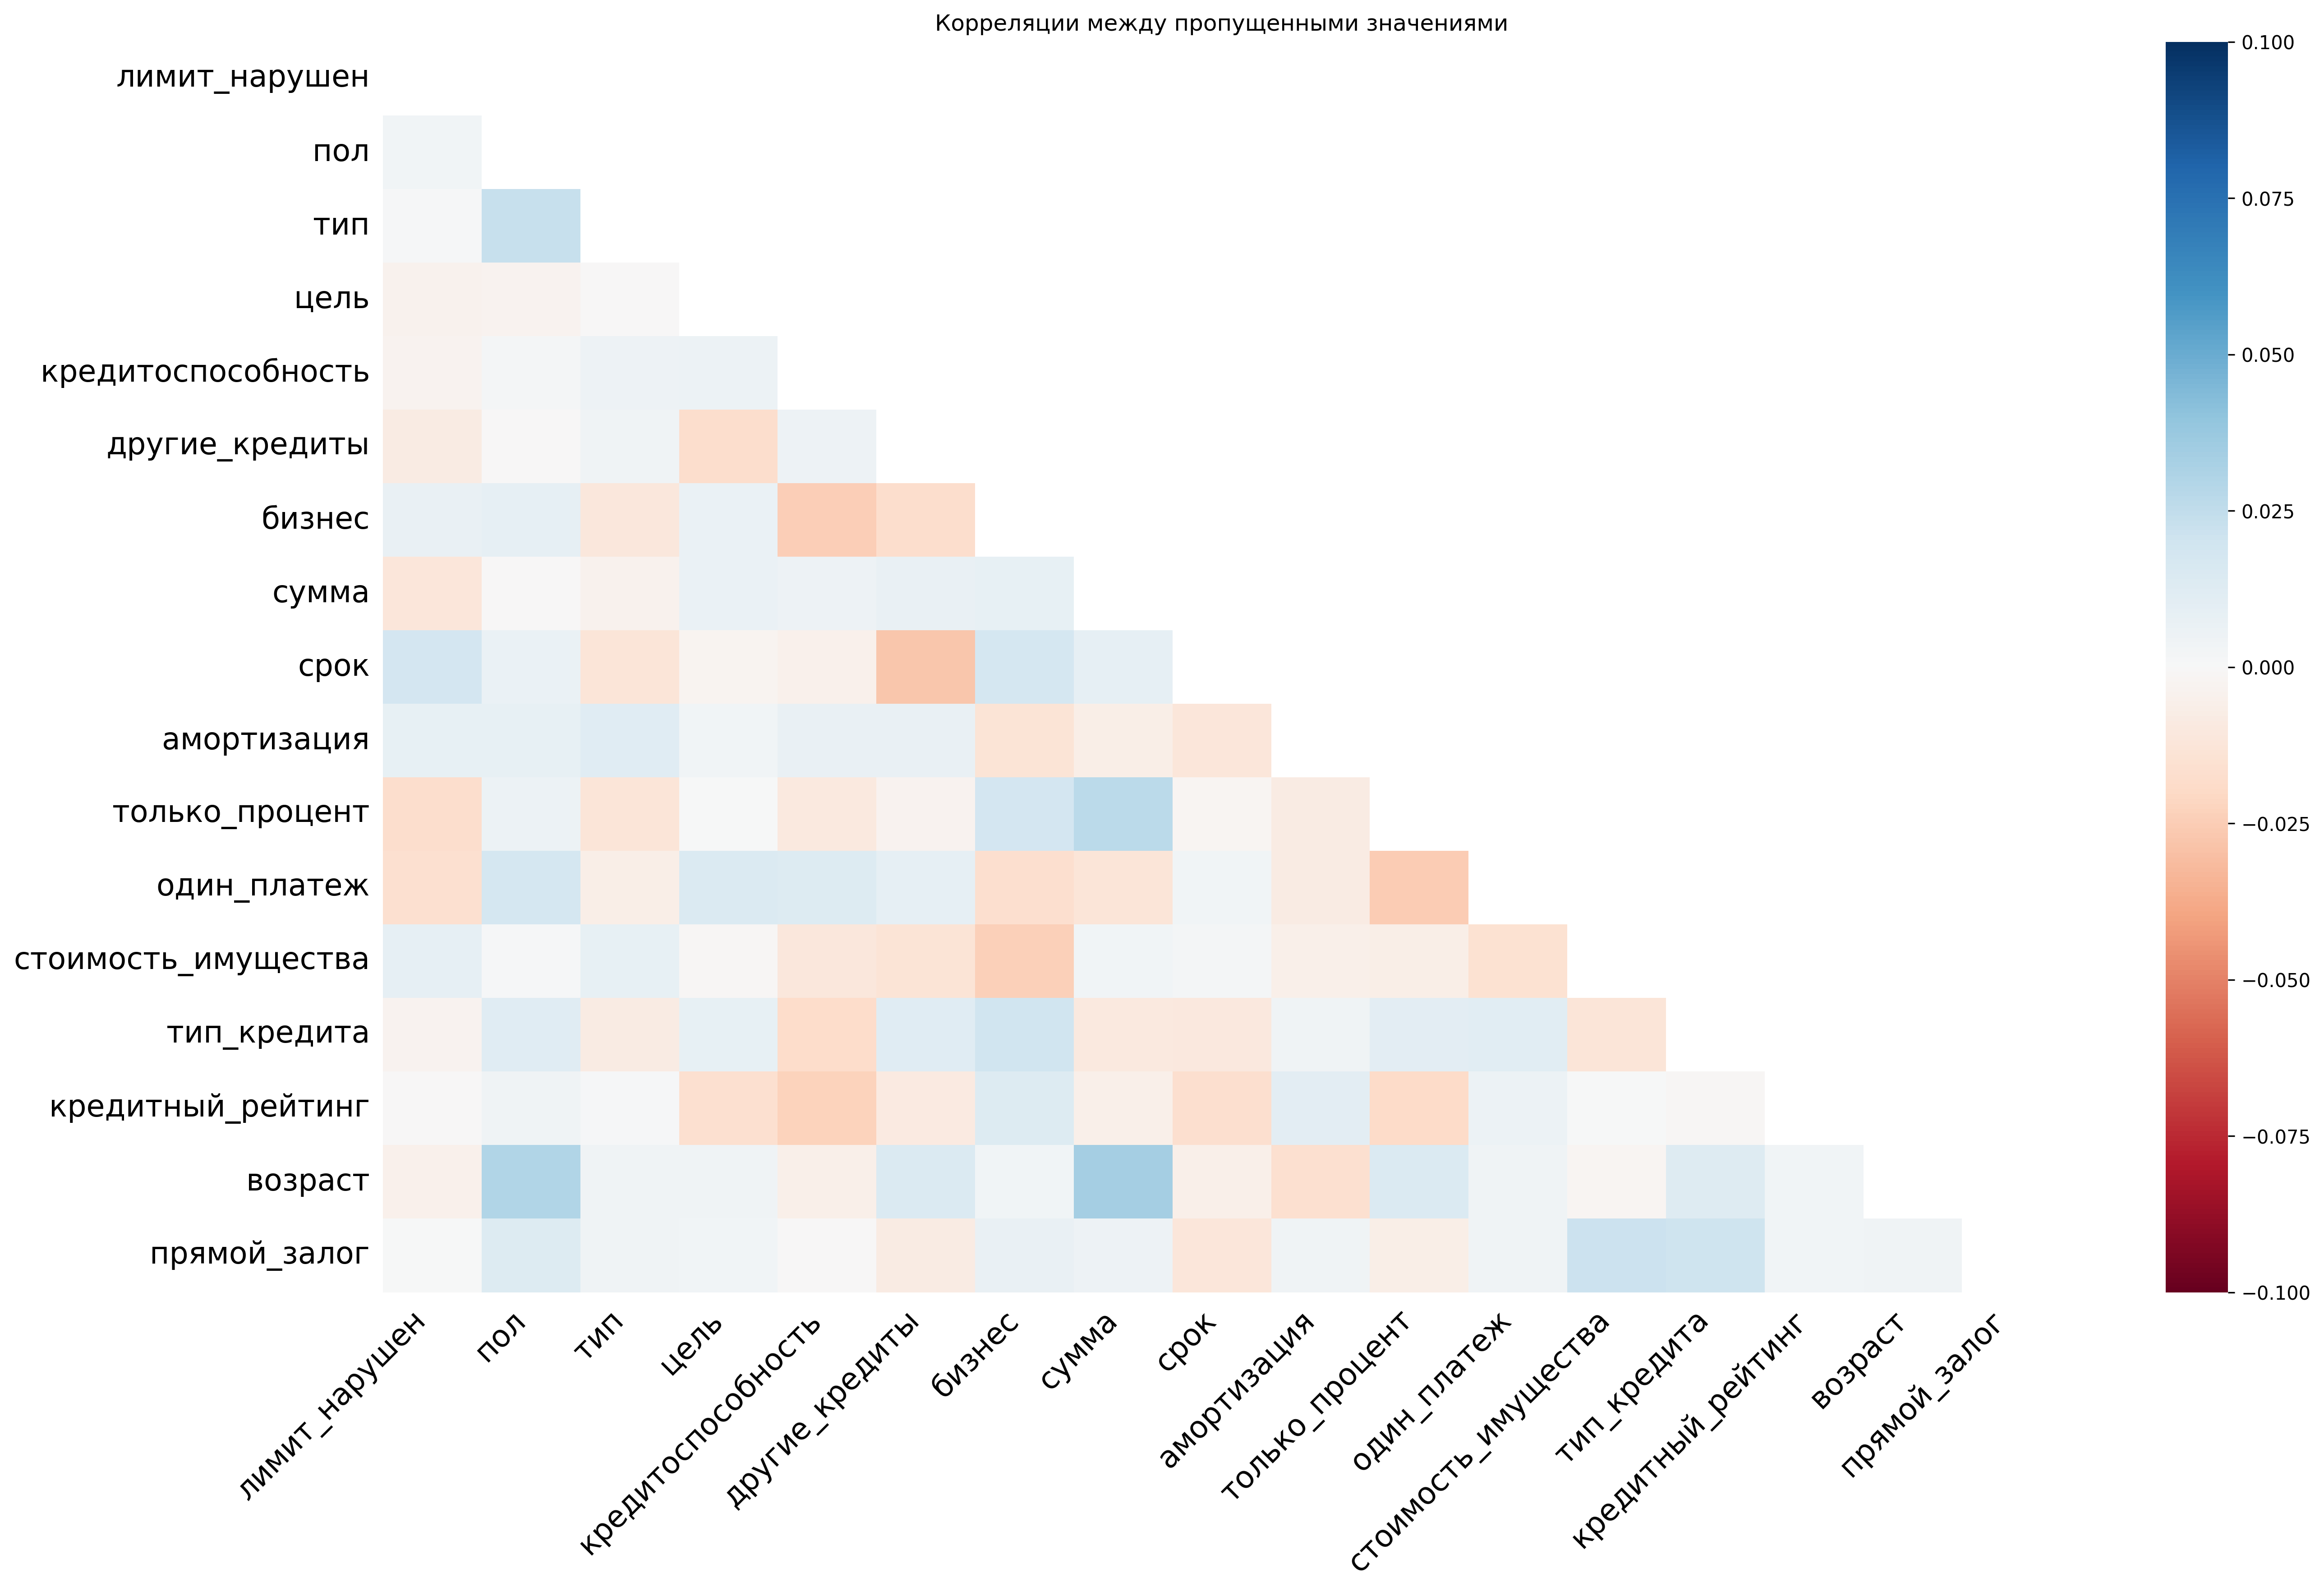

In [5]:
vis.plot_nan(loan_data)

## Train

In [6]:
def impute_nans(df):
    df = df.copy()

    col_to_nan_value = {
        "лимит_нарушен": 3,
        "пол": "nan",
        "тип": 0,
        "цель": 4,
        "кредитоспособность": 2,
        "другие_кредиты": 2,
        "бизнес": 2,
        "амортизация": 2,
        "только_процент": 2,
        "один_платеж": 2,
        "тип_кредита": 0,
        "прямой_залог": 0,
    }

    for name, val in col_to_nan_value.items():
        df[name] = df[name].fillna(val)

    return df


In [7]:
from typing import Self
from sklearn.impute import KNNImputer


class Processor:
    def __init__(self, X) -> None:
        X = X.drop(columns="дефолт")
        self.cols_to_impute = ["кредитный_рейтинг", "стоимость_имущества", "срок", "сумма"]
        self.cols_to_encode = ["пол", "проживание"]
        self.cols_to_remove = ["сбор", "тип_залога", "возраст"]
        self.float_cols = ["сумма", "срок", "кредитный_рейтинг", "стоимость_имущества"]

        self.all_cols = list(X.columns)
        for name in self.cols_to_remove:
            self.all_cols.remove(name)

    def fit(self, X, y=None) -> Self:
        X = X.copy()
        X = X[self.all_cols]

        self.imputer = KNNImputer()
        self.encoder = OrdinalEncoder()
        self.scaler = StandardScaler()

        self.texter = transforms.TextFeaturesExtractor("речь")

        X = impute_nans(X)
        X[self.cols_to_encode] = self.encoder.fit_transform(X[self.cols_to_encode])
        self.imputer.fit(X[self.cols_to_impute])
        self.scaler.fit(X[self.float_cols])
        self.texter.fit(X)

    def transform(self, X, y=None) -> pd.DataFrame:
        X = X.copy()
        X = X[self.all_cols]

        X = impute_nans(X)
        X[self.cols_to_encode] = self.encoder.transform(X[self.cols_to_encode])
        X[self.cols_to_impute] = self.imputer.transform(X[self.cols_to_impute])
        X[self.float_cols] = self.scaler.transform(X[self.float_cols])
        X = self.texter.transform(X)
        return X


def train(df: pd.DataFrame) -> None:
    df = df.copy()
    df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

    processor = Processor(df_train)
    # df_train = transforms.remove_anomalies(df_train, processor.float_cols)
    df_train = df_train[df_train["прямой_залог"] != 0]
    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    processor.fit(X_train)
    X_train = processor.transform(X_train)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    print("Train")
    modeling.print_metrics(y_true=y_train, y_pred=pred_train)

    X_test = processor.transform(X_test)
    pred = model.predict(X_test)
    print("Test")
    modeling.print_metrics(y_true=y_test, y_pred=pred)
    return processor, model


processor, model = train(loan_data)

Train
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
Test
Accuracy: 0.829
Precision: 0.949
Recall: 0.335
f1: 0.496


In [22]:
df_eval = pd.read_csv("data/test_data.csv")
X_eval = df_eval.drop(columns="дефолт")
y_eval = df_eval["дефолт"]

eval_pred = model.predict(processor.transform(X_eval))
print("Test")
modeling.print_metrics(y_true=y_eval, y_pred=eval_pred)


Test
Accuracy: 0.840
Precision: 0.952
Recall: 0.338
f1: 0.499


In [24]:
business.profit(y_eval, eval_pred, X_eval)

55967706.64546475